In [1]:
import Pkg;
Pkg.add("Plots")
Pkg.add("Statistics")
Pkg.add("PyPlot") #on-the-fly animation using pyplot backend seems less flickers
Pkg.add("PyCall")

   Updating registry at `C:\Users\Ajay Arvind\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\Ajay Arvind\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Ajay Arvind\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\Ajay Arvind\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Ajay Arvind\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\Ajay Arvind\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Ajay Arvind\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\Ajay Arvind\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Ajay Arvind\.julia\environments\v1.5\Manifest.toml`


In [2]:
using Plots, Statistics, Random, StatsBase, DelimitedFiles, WebIO

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16620333477947099453\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-3390841520539757024\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-16620333477947099453\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

## Create connectivity matrix

In [3]:
function connectivity_matrix(L, enter = [2])
    c = zeros(L+2, L+2)
    for i=2:L+1
        c[i,i+1] = 1
    end
    for e in enter
        c[1,e] = 1
    end
    c[end,end] = 1
    return c
end

connectivity_matrix (generic function with 2 methods)

## Create function to add junctions
    
    Using the PyCall library, we have rendered Python code in Julia! 

In [4]:
using PyCall

py"""
import numpy as np 

def add_junction(main, pos, branches):
    length = len(main)
    branch_lens = []
    for branch in branches:
        branch_lens.append(len(branch) - 2)
    length += sum(branch_lens)
    C = np.zeros((length, length))
    C[:len(main)-2, :len(main)] = main[:-2]
    C[len(main)-2][-1] = 1
    branch_start = len(main)-1
    for branch in branches:
        C[pos, branch_start] = 1
        C[branch_start:branch_start+len(branch)-3, branch_start+1:branch_start+len(branch)-1] += branch[1:-2, 2:]
        C[branch_start+len(branch)-3, -1] = 1
        branch_start += len(branch) - 2
    C[-1, -1] = 1
    return C
"""

## Function to initialize History Matrix

In [5]:
function initialize_H(tM, NC)
    # tM maximum number of time steps
    # NC is the number of cars
    return H = zeros(Int16,NC, tM+2);
end

initialize_H (generic function with 1 method)

## Function to find all positions available

Function analyzes the connectivity matrix for available positions, as well as History matrix to handle overlap of positions


In [6]:
function find_pos_available(ic, it, H, C, L) 
    # ic is the car number 
    # it is the time step 
    # H matrix of histories 
    # C connectivity matrix 
    # L is the number of positions 
    
    ip = copy(H[ic,it]); #position of the car 
    
    # indices of '1' entries, subarray start from 2, no need to minus 1
    reachable=findall(x->x==1,C[ip+1,2:end]) 
    
    # a list of occupied position excluding 0 and L+1
    occupied=filter(x-> x>0 && x<L+1,H[:,it])
    
    # available positions are reachable - occupied
    # setdiff(s1,s2): construct elements in set s1 but not in set s2
    return setdiff(reachable,occupied)
    
end

find_pos_available (generic function with 1 method)

## Function which moves a single car

In [7]:
function move_car(ic,it,H,C, L, p_mov)
    # ic is the car number
    # H matrix of histories
    # it time step
    # C connectivity matrix
    # p_mov is the probability to move
    H[ic, it+1] = copy(H[ic, it]); 
    
    # calls one of the above functions to find avail positions
    vec_pos = find_pos_available(ic, it, H, C,L);
    aux = size(vec_pos);
    n_pos = copy(aux[1]);
    
    # if there are possible positions (i.e., finite number of elements)
    if n_pos>0
        
        r = rand();# vector containing one random element <= 1
        
        if r<p_mov[1]
            # randomly picks one of the possible positions
            i_pos = rand(1:n_pos,1,1);
            
            # uses randomly selected possible position as next position
            H[ic, it+1] = copy(vec_pos[i_pos[1]]); 
        end
    end
    return H
end

move_car (generic function with 1 method)

## Function which finds and resolves conflicts
The function utilizes the history matrix to analyze each of the positions and ensures that there are no conflicts such as overlap

In [8]:
function find_resolve_conflicts(H, L, it) 
    # it is the time step 
    # H matrix of histories 
    # L is the number of positions 
    Hn = copy(H); 
    for iL = 1:L
        list_cars=findall(x->x==iL,H[:,it])
        if length(list_cars)>1
            shuffle!(list_cars)            
            Hn[list_cars,it]=copy(H[list_cars,it-1])
            Hn[list_cars[1], it] = copy(H[list_cars[1], it]);
        end
    end
    return Hn 
end 

find_resolve_conflicts (generic function with 1 method)

## Function which moves all the cars

A collation of all the resolved functions


In [9]:
function next_step(H, p_mov, it, C, L)
    # H matrix of histories
    # p_inj probability of injecting
    # p_mov probability of moving
    # it time step
    # C connectivity matrix
    
    aux = size(H);
    NC = copy(aux[1]); 
    
    # loop over all cars, move one car at a time
    for ic = 1:NC
         H = move_car(ic,it,H,C, L, p_mov[ic]); # this function moves a car
    end
    
    H = find_resolve_conflicts(H, L, it+1); # this function finds and resolves conflicts -> to be done
    
    return H
end

next_step (generic function with 1 method)

## Function to plot the grid in which cars move

Gives the visual cue for each of the car's movements

In [10]:
function plotMapFromConnectivity(C,nCol,nRow;hotspot=nothing)
    # C is the connectivity matrix
    # nCol is the number of columns
    # nRow is the number of rows
    # hotspot, a keyword argument, is the congested spot which default to nothing
    
    # rectrangular patch
    rect(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
    # convert 1D to 2D index
    getXY= (x) -> ((x.-1) .% nCol .+ 1,(x.-1) .÷ nCol .+ 1 ) ;
    
    plot(xlim=(0,nCol), xticks=[0:nCol;],ylim=(0,nRow),yticks=[0:nRow;],
        legend=false,aspect_ratio=:equal,framestyle=:box,
        grid=true,foreground_color_grid=:black,gridalpha=1,gridlinewidth=1)
    
#     unreachable cells: black
    s=dropdims(sum(C[1:end-1,2:end-1],dims=1),dims=1)
    for i in findall(x->x==0,s)
        x,y=getXY(i)
        plot!(rect(1,1,x-1,y-1),color=:black)
    end
    
#     entry sites: transparent green
    entries=findall(x->x==1,C[1,:])
    for i in entries
        x,y=getXY(i-1)
        plot!(rect(1,1,x-1,y-1),color=:green,opacity=0.2,
            annotation = [(x-0.5, y-0.2, "entry")],annotationfontsize=8)
    end   
    
#     exit sites: transparent red
    exits=findall(x->x==1,C[2:end-1,end])
    for i in exits
        x,y=getXY(i)
        plot!(rect(1,1,x-1,y-1),color=:red,opacity=0.2,
            annotation = [(x-0.5, y-0.8, "exit")],annotationfontsize=8)
    end

#  connected site: arrow   
    s=dropdims(sum(C[2:end-1,2:end-1],dims=2),dims=2)    
    for r in findall(x->x>0,s)
        reachable=findall(x->x==1,C[r+1,2:end-1])
        x0,y0=getXY(r) 
        x1,y1=getXY(reachable)
        dx,dy=x1.-x0,y1.-y0;
        quiver!([x0-0.5].+0.25.*dx,[y0-0.5].+0.25.*dy,
                quiver=((dx.*0.5,dy.*0.5)),color=:black)
    end
    
#  hotspot: dotted outline
    if !isnothing(hotspot)
        for i in hotspot
            x,y=getXY(i)
            plot!([x-1,x-1,x,x,x-1],[y-1,y,y,y-1,y-1],color=:red,linewidth=3,linestyle=:dot)
        end
    end
    return current()
end

plotMapFromConnectivity (generic function with 1 method)

## Function which provides a general function to plot all cars at a certain instance of time

In [11]:
function plotAllCarAtOneInstant(H,t,nCol,nRow;c=palette(:tab10))
    # H is the history matrix
    # t is time step
    # nCol is the number of columns
    # nRow is the number of rows
    # c, a keyword argument, is the color palette which default to tab10
    pos=H[:,t];
    maxNodes=nCol*nRow;
    getXY= (x) -> ((x.-1) .% nCol .+ 1,(x.-1) .÷ nCol .+ 1 ) ;    
    
    id=findall(x->x>0 && x<=maxNodes,pos);
    x,y=getXY(pos[id]);
    annot=[(xx-0.5,yy-0.5,"$(i)") for (i,xx,yy) in zip(id,x,y)];
    shape=[:circle for i in id];
    (t>1) && (shape[H[id,t-1].==0].=:diamond);
    
    return scatter!(x.-0.5,y.-0.5,color=c[(id.-1).%length(c).+1],
                    title="t=$(t-1)",
                    annotation = annot, annotationfontsize=9,
                    markershape=shape, markersize=16, markerstrokewidth=2)
end

plotAllCarAtOneInstant (generic function with 1 method)

## Function which creates the animations 

In [12]:
function plotHistory(H,C,nCol,nRow;delay=0.5,hotspot=nothing)
    # H is the history matrix
    # C is the connectivity matrix
    # nCol is the number of columns
    # nRow is the number of rows
    # delay, a keyword argument, is the pause between frame which default to 0.5s
    # hotspot, a keyword argument, is the congested spot which default to nothing
    nCar,tMax=size(H);
    tMax=min(tMax,tMax-sum(sum(H.==nCol*nRow+1,dims=1).==nCar)+1);
    pmap=plotMapFromConnectivity(C,nCol,nRow,hotspot=hotspot);
    for i=1:tMax
        IJulia.clear_output(true)
        plot(deepcopy(pmap))
        plotAllCarAtOneInstant(H,i,nCol,nRow);
        display(current())
        sleep(delay)
    end
    IJulia.clear_output(true)
    return
end

plotHistory (generic function with 1 method)

## Function which plots the congestion graph, and calculates net congestion


In [13]:
function congest_plot(H,a,b,L)
    ## H is the history matrix
    # a is the starting time chosen to check congestion
    # b is the final time
    # L is the number of sites
    
    counter=zeros(Int64,L) # the histogram 
    
    # use run length encoding to count
    for row in eachrow(H[:,a:b])
        p=filter(x-> x>0 && x<=L,row)
        for (k,l) in zip(rle(p)...) # run length
            counter[k]+= l-1 #do not count the first occurence
        end
    end    
    
    # implementation 2: only traverse H once
#     for row in eachrow(H[:,a:b])
#         iter = Iterators.filter(x-> x>0 && x<=L,row)
#         (item1, state) = iterate(iter)
#         while (iter2=iterate(iter, state)) != nothing
#             (item2, state) = iter2        
#             item1==item2 && (counter[item1]+=1)
#             item1=item2
#         end
#     end
    
    x_point=findall(x->x==maximum(counter),counter)
    
    display(bar(counter,bar_edges=true,bar_width=1,xticks=[1:L;],
                title = "Congestion plot from time t=$a to t=$b", 
                xlabel = "Position", ylabel = "Net Congestion",
                legend=false,titlefontsize=12))
        
    println("The maximum congestion is at position $x_point during the time t=$a to t=$b")
    return x_point
end

congest_plot (generic function with 1 method)

## Function which determines the time taken to travel from a position 'a' to 'b'

In [14]:
function time_taken(H, a, b)
    # calculate the time taken by each car from positon a to position b given the history matrix
    # H history matrix
    # a start position
    # b final position
    # tt is the vector that stores the time taken to go from a to b by each car
   
    tt=Int64[]
    for row in eachrow(H)
        (i_a=findfirst(x->x==a,row)) == nothing && continue;
        (i_b=findnext(x->x==b,row,i_a+1)) == nothing && continue;
        append!(tt,i_b-i_a)
    end

    display(histogram(tt, nbins=abs(b-a), 
            title = "Time taken to travel from $a to $b", 
            xlabel = "Time taken", ylabel = "Number of cars",
            legend=false,titlefontsize=12)) 
   
    println("The average time taken by cars to travel from position $a to $b is $(mean(tt)) ")
    println("The variance of the time taken by cars to travel from $a to $b is $(var(tt)) ")
    println("The standard deviation of the time taken by cars to travel from $a to $b is $(std(tt)) ")
    return tt
end 

time_taken (generic function with 1 method)

## Initialization of matrices and movements


In [15]:
NC = 25; # number of cars
tM = 125; # total time steps
p_mov = [rand(0.3:0.0001:0.7) for i = 1:NC]; # probability of moving
L = 8; # number of sites

C = py"add_junction"(connectivity_matrix(4, [2, 4]), 2, [connectivity_matrix(2), connectivity_matrix(2)])

H = initialize_H(tM, NC);

for it = 1:tM+1
    H = next_step(H, p_mov, it, C, L);
end

## Provides the information regarding the journey for the junction path and plots the congestion graph


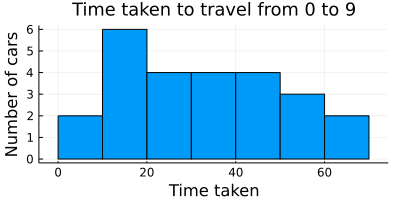

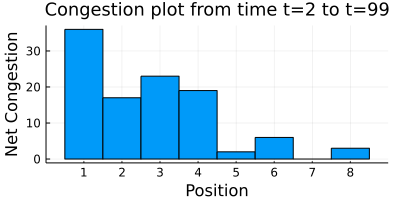

The average time taken by cars to travel from position 0 to 9 is 33.04 
The variance of the time taken by cars to travel from 0 to 9 is 319.79 
The standard deviation of the time taken by cars to travel from 0 to 9 is 17.88267317824715 
The maximum congestion is at position [1] during the time t=2 to t=99


In [16]:
#a=starting position 
#b=final position
#time taken to calculate from point a to point b
#t1 is time from which congestion is checked
#t2 is final time upto which congestion is noted
a = 0;
b = 9;
t1 = 2;
t2 = 99;
gr(size=(400,200))
ttime1 = time_taken(H, a, b);
ct = congest_plot(H,t1,t2,L);

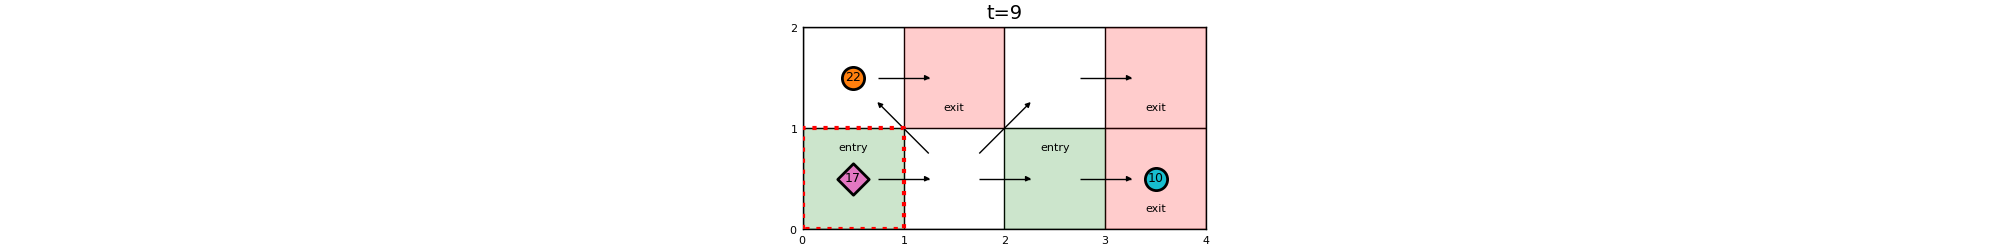

In [17]:
pyplot(size=(2000,250));
t=10
nCol,nRow=4,2
plotMapFromConnectivity(C,nCol,nRow,hotspot=ct);
plotAllCarAtOneInstant(H,t,nCol,nRow)

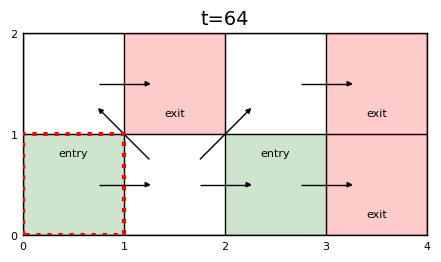

In [18]:
pyplot(size=(2000,250))
nCol,nRow=4,2
plotHistory(H,C,nCol,nRow;delay=0.1,hotspot=ct)

## Provides the information regarding the journey for the straight line path of length 4 and plots the congestion graph

In [19]:
tM = 125; # total time steps
L = 4; # number of sites

C = connectivity_matrix(4, [2, 4])

H = initialize_H(tM, NC);

for it = 1:tM+1
    H = next_step(H, p_mov, it, C, L);
end

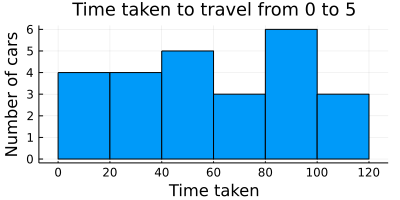

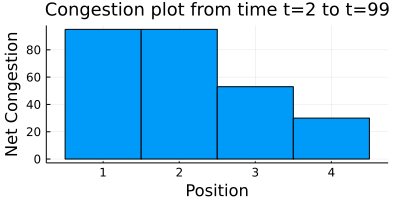

The average time taken by cars to travel from position 0 to 5 is 59.0 
The variance of the time taken by cars to travel from 0 to 5 is 1122.25 
The standard deviation of the time taken by cars to travel from 0 to 5 is 33.5 
The maximum congestion is at position [1, 2] during the time t=2 to t=99


In [20]:
#a=starting position 
#b=final position
#time taken to calculate from point a to point b
#t1 is time from which congestion is checked
#t2 is final time upto which congestion is noted
a = 0;
b = 5;
t1 = 2;
t2 =  99;
gr(size=(400,200))
ttime2 = time_taken(H, a, b);
ct = congest_plot(H,t1,t2,L);

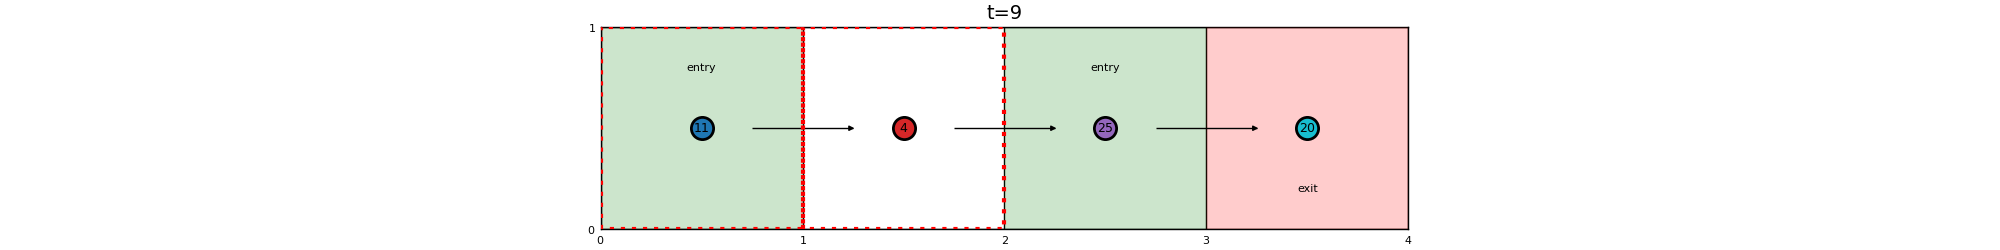

In [21]:
pyplot(size=(2000,250));
t=10
nCol,nRow=4,1
plotMapFromConnectivity(C,nCol,nRow,hotspot=ct);
plotAllCarAtOneInstant(H,t,nCol,nRow)

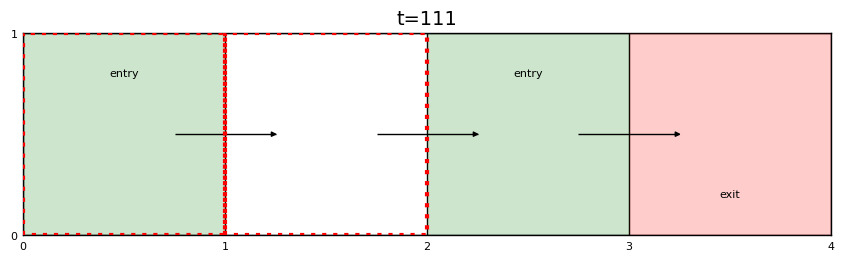

In [22]:
pyplot(size=(2000,250))
nCol,nRow=4,1
plotHistory(H,C,nCol,nRow;delay=0.1,hotspot=ct)

## Provides the information regarding the journey for the straight line path of length 8 and plots the congestion graph

In [23]:
tM = 125; # total time steps
L = 8; # number of sites

C = connectivity_matrix(8, [2, 4])

H = initialize_H(tM, NC);

for it = 1:tM+1
    H = next_step(H, p_mov, it, C, L);
end

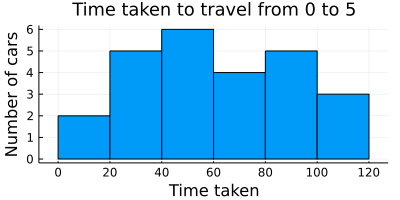

The average time taken by cars to travel from position 0 to 5 is 58.72 

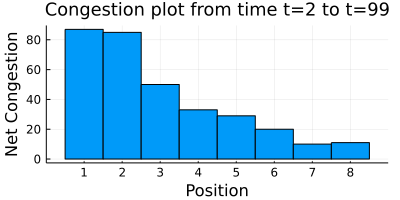


The variance of the time taken by cars to travel from 0 to 5 is 903.0433333333334 
The standard deviation of the time taken by cars to travel from 0 to 5 is 30.050679415502962 
The maximum congestion is at position [1] during the time t=2 to t=99


In [24]:
#a=starting position 
#b=final position
#time taken to calculate from point a to point b
#t1 is time from which congestion is checked
#t2 is final time upto which congestion is noted
a = 0;
b = 5;
t1 = 2;
t2 =  99;
gr(size=(400,200))
ttime3 = time_taken(H, a, b);
ct = congest_plot(H,t1,t2,L);

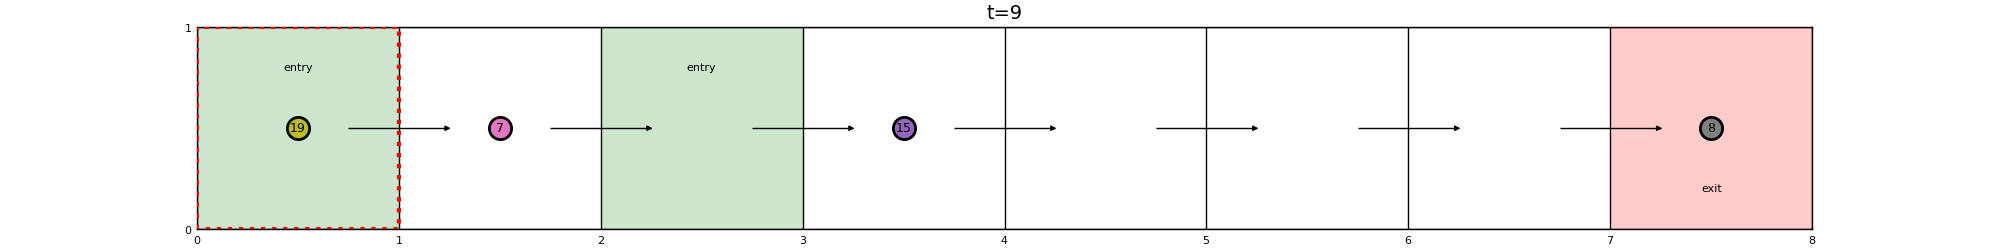

In [25]:
pyplot(size=(2000,250));
t=10
nCol,nRow=8,1
plotMapFromConnectivity(C,nCol,nRow,hotspot=ct);
plotAllCarAtOneInstant(H,t,nCol,nRow)

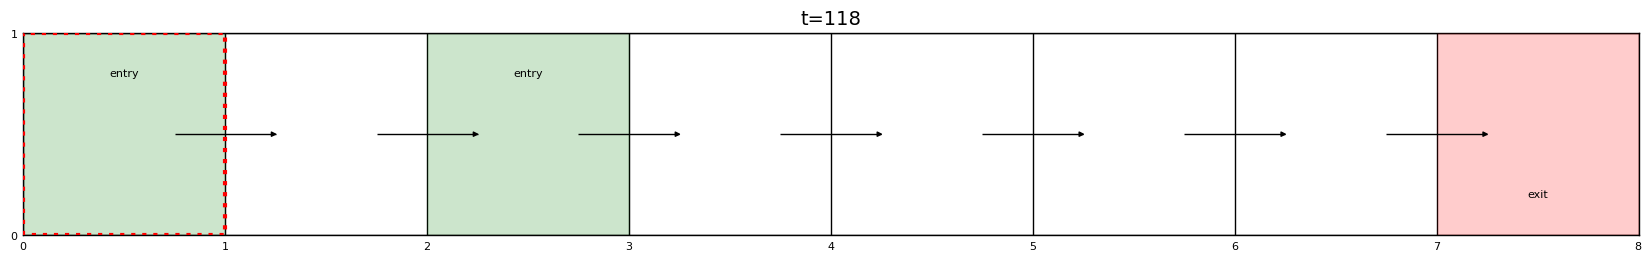

In [26]:
pyplot(size=(2000,250))
nCol,nRow=8,1
plotHistory(H,C,nCol,nRow;delay=0.1,hotspot=ct)

## Comparitive study between the congestions and average times of the junction path and the straight path


In [27]:
##compare

print("Variance of junction path: ", var(ttime1))
print("\nVariance of straight path: ", var(ttime2))

print("\n\nStandard Deviation of junction path: ", std(ttime1))
print("\nStandard Deviation of straight path: ", std(ttime2))

print("\n\nAverage time of junction path: ", mean(ttime1))
print("\nAverage time of straight path: ", mean(ttime2))

Variance of junction path: 319.79
Variance of straight path: 1122.25

Standard Deviation of junction path: 17.88267317824715
Standard Deviation of straight path: 33.5

Average time of junction path: 33.04
Average time of straight path: 59.0

## Comparitive study between the congestions and average times of the straight line path of length 4 and length 8

In [28]:
##compare

print("Variance of straight path of length 4: ", var(ttime2))
print("\nVariance of straight path of length 8: ", var(ttime3))

print("\n\nStandard Deviation of straight path of length 4: ", std(ttime2))
print("\nStandard Deviation of straight path of length 8: ", std(ttime3))

print("\n\nAverage time of straight path of length 4: ", mean(ttime2))
print("\nAverage time of straight path of length 8: ", mean(ttime3))

Variance of straight path of length 4: 1122.25
Variance of straight path of length 8: 903.0433333333334

Standard Deviation of straight path of length 4: 33.5
Standard Deviation of straight path of length 8: 30.050679415502962

Average time of straight path of length 4: 59.0
Average time of straight path of length 8: 58.72